In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import sklearn
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/")

In [5]:
csv = 'clean_article.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,article,target,length
0,karachi in long and detailed rejoinder to his ...,1,4864
1,islamabad meeting of the economic coordination...,1,3709
2,lahore punjab finance minister dr ayesha ghaus...,0,1918
3,islamabad the sec ur ities and exchange com mi...,1,2373
4,islamabad new report by the world bank reveals...,0,2378


In [6]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  2329 non-null   object
 1   target   2329 non-null   int64 
 2   length   2329 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


In [7]:
x = my_df.article
y = my_df.target

In [8]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [9]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1863 entries with 42.78% negative, 57.22% positive
Validation set has total 233 entries with 45.06% negative, 54.94% positive
Test set has total 233 entries with 41.63% negative, 58.37% positive


In [10]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [8]:
def labelize_article_ug(article,label):
    result = []
    prefix = label
    for i, t in zip(article.index, article):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [9]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_article_ug(all_x, 'all')

In [17]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 2329/2329 [00:00<00:00, 986720.61it/s]


In [18]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 2329/2329 [00:00<00:00, 672208.51it/s]


CPU times: user 49.9 s, sys: 313 ms, total: 50.2 s
Wall time: 27.1 s


In [19]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 2329/2329 [00:00<00:00, 1059493.93it/s]


In [20]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 2329/2329 [00:00<00:00, 1434650.32it/s]


CPU times: user 1min 47s, sys: 463 ms, total: 1min 47s
Wall time: 59.5 s


In [21]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

# Prepration for Convolutional Neural Network

So far, we have aggregated the word vectors of each word in an article, either summation or calculating mean to get one vector representation of each article. However, in order to feed to a CNN, we have to not only feed each word vector to the model, but also in a sequence which matches the original tweet.

A neural network model will expect all the data to have the same dimension, but in case of different sentences, they will have different lengths. This can be handled with padding.

Let's first load the Word2Vec models to extract word vectors from. this can easily be loaded with "KeyedVectors" function in Gensim. We have two different Word2Vec models, one with CBOW (Continuous Bag Of Words) model, and the other with a skip-gram model.

In [22]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [23]:
len(model_ug_cbow.wv.vocab.keys())

13647

By running below code block, we are constructing a sort of dictionary I can extract the word vectors from. Since I have two different Word2Vec models, below "embedding_index" will have concatenated vectors of the two models. For each model, I have 100 dimension vector representation of the words, and by concatenating each word will have 200 dimension vector representation.

In [24]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 13647 word vectors.


Now we have our reference to word vectors ready, but we still haven't prepared data to be in the format. Keras' 'Tokenizer' will split each word in a sentence, then we can call 'texts_to_sequences' method to get the sequential representation of each sentence. We also need to pass 'num_words' which is a number of vocabularies you want to use, and this will be applied when you call 'texts_to_sequences' method. This might be a bit counter-intuitive since if you check the length of all the word index, it will not be the number of words you defined, but the actual screening process happens when you call 'texts_to_sequences' method.

In [25]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [26]:
len(tokenizer.word_index)

19065

Below are the first five entries of the original train data.

In [27]:
for x in x_train[:5]:
    print(x)

karachi banking profits declined substantially in july september according to the quarterly compendium issued by the state bank of pakistan sbp on wednesday experts said the decline was mainly due to major cut in habib bank bottom line as it paid heavy penalty to the us banking regulator banks earned total profit of rs billion in january september as opposed to rs bn year ago they earned just rs bn in july september against earnings of rs bn in april june sbp data showed banking profits declined because habib bank had to pay about rs bn as penalty to the us regulator and this outflow has been adjusted in the third quarter said samiullah tariq director of research at arif habib ltd habib bank announced in the first week of september that it would pay million to the us regulator and surrendered the licence to carry out banking business in the united states total assets of the banking industry increased to trillion at the end of september from rs tr on june advances dropped in the third q

And the same data prepared as sequential data is as below.

In [ ]:
sequences[:5]

Each word is represented as a number, and we can see that the number of words in each sentence is matching the length of numbers in the "sequences". We can later make connections of which word each number represents. But we still didn't pad our data, so each sentence has varying length. Let's deal with this.

In [29]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [30]:
max(length)

1267

The maximum number of words in a sentence within the training data is 1267. Let's decide the maximum length to be a bit longer than this, let's say 1500.

In [31]:
x_train_seq = pad_sequences(sequences, maxlen=1500)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1863, 1500)


In [32]:
x_train_seq[:5]

array([[   0,    0,    0, ...,   34, 2861,   56],
       [   0,    0,    0, ...,  746,    3,  103],
       [   0,    0,    0, ..., 9844,  462, 7292],
       [   0,    0,    0, ...,  182,  130, 2145],
       [   0,    0,    0, ...,  293,  390, 1997]], dtype=int32)

As you can see from the padded sequences, all the data now transformed to have the same length of 1500, and by default, Keras zero-pads at the beginning, if a sentence length is shorter than the maximum length. If you want to know more in detail, please check the Keras documentation on sequence preprocessing. https://keras.io/preprocessing/sequence/

In [33]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=1500)

There's still one more thing left to do before we can feed the sequential text data to a model. When we transformed a sentence into a sequence, each word is represented by an integer number. Actually, these numbers are where each word is stored in the tokenizer's word index. Keeping this in mind, let's build a matrix of these word vectors, but this time we will use the word index number so that our model can refer to the corresponding vector when fed with integer sequence.

Below, I am defining the number of words to be 100,000. This means I will only care about 100,000 most frequent words in the training set. If I don't limit the number of words, the total number of vocabulary will be more than 200,000.

In [34]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

As a sanity check, if the embedding matrix has been generated properly. In the above, when we saw the first five entries of the training set, the first entry ended with  "growth", and the sequential representation of this was [55 , ...., 56]. Let's see if 56th embedding matrix is as same as vectors for the word 'growth'.

In [35]:
np.array_equal(embedding_matrix[56] ,embeddings_index.get('growth'))

True

Now we are ready with the data preparation. Before we jump into CNN, I would like to test one more thing (sorry for the delay). When we feed this sequential vector representation of data, we will use Embedding layer in Keras. With Embedding layer, I can either pass pre-defined embedding, which I prepared as 'embedding_matrix' above, or Embedding layer itself can learn word embeddings as the whole model trains. And another possibility is we can still feed the pre-defined embedding but make it trainable so that it will update the values of vectors as the model trains.

In order to check which method performs better, I defined a simple shallow neural network one hidden layer. For this model structure, I will not try to refine models by tweaking parameters, since the main purpose is to implement CNN.

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [36]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Embedding

In [37]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=1500, trainable=False) #Using pre-trained Word2Vec
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
59/59 - 27s - loss: 0.8733 - accuracy: 0.5862 - val_loss: 0.6929 - val_accuracy: 0.5708 - 27s/epoch - 465ms/step
Epoch 2/5
59/59 - 25s - loss: 0.3724 - accuracy: 0.8218 - val_loss: 0.7405 - val_accuracy: 0.5880 - 25s/epoch - 428ms/step
Epoch 3/5
59/59 - 26s - loss: 0.0932 - accuracy: 0.9817 - val_loss: 0.8603 - val_accuracy: 0.5923 - 26s/epoch - 444ms/step
Epoch 4/5
59/59 - 25s - loss: 0.0225 - accuracy: 0.9973 - val_loss: 0.9532 - val_accuracy: 0.5966 - 25s/epoch - 426ms/step
Epoch 5/5
59/59 - 25s - loss: 0.0175 - accuracy: 0.9973 - val_loss: 0.9928 - val_accuracy: 0.5708 - 25s/epoch - 426ms/step


In [38]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=1500) #learn word embedding from scratch
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
59/59 - 59s - loss: 1.9013 - accuracy: 0.5330 - val_loss: 0.6820 - val_accuracy: 0.5579 - 59s/epoch - 1s/step
Epoch 2/5
59/59 - 57s - loss: 0.3647 - accuracy: 0.9050 - val_loss: 0.6587 - val_accuracy: 0.6094 - 57s/epoch - 967ms/step
Epoch 3/5
59/59 - 53s - loss: 0.1050 - accuracy: 0.9936 - val_loss: 0.6538 - val_accuracy: 0.6223 - 53s/epoch - 899ms/step
Epoch 4/5
59/59 - 55s - loss: 0.0345 - accuracy: 0.9968 - val_loss: 0.6583 - val_accuracy: 0.6652 - 55s/epoch - 931ms/step
Epoch 5/5
59/59 - 53s - loss: 0.0161 - accuracy: 0.9984 - val_loss: 0.6419 - val_accuracy: 0.6524 - 53s/epoch - 895ms/step


In [39]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=1500, trainable=True) #fine-tune pre-trained Word2Vec
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
59/59 - 61s - loss: 1.1117 - accuracy: 0.5700 - val_loss: 0.6522 - val_accuracy: 0.6309 - 61s/epoch - 1s/step
Epoch 2/5
59/59 - 53s - loss: 0.2464 - accuracy: 0.9147 - val_loss: 0.7800 - val_accuracy: 0.6395 - 53s/epoch - 898ms/step
Epoch 3/5
59/59 - 53s - loss: 0.0537 - accuracy: 0.9882 - val_loss: 0.8560 - val_accuracy: 0.6266 - 53s/epoch - 897ms/step
Epoch 4/5
59/59 - 59s - loss: 0.0168 - accuracy: 0.9979 - val_loss: 0.9390 - val_accuracy: 0.6266 - 59s/epoch - 992ms/step
Epoch 5/5
59/59 - 53s - loss: 0.0130 - accuracy: 0.9968 - val_loss: 1.0031 - val_accuracy: 0.6094 - 53s/epoch - 895ms/step


As a result, the best validation accuracy is from the third method (fine-tune pre-trained Word2Vec) at 63.95%. The best training accuracy is the third method at 99.84%. Using pre-trained Word2Vec without updating its vector values showed the lowest accuracy both in training and validation. However, what's interesting is that in terms of training set accuracy, fine-tuning pre-trained word vectors couldn't outperform the word embeddings learned from scratch through the embedding layer. Before I tried the above three methods, my first guess was that if I fine-tune the pre-trained word vectors, it would give me the best training accuracy.

Feeding pre-trained word vectors for an embedding layer to update is like providing the first initialisation guideline to the embedding layer so that it can learn more efficiently the task-specific word vectors. But the result is somewhat counterintuitive, and in this case, it turns out that it is better to force the embedding layer to learn from scratch.

But premature generalization is a dangerous step to take. For this reason, I will compare three methods again in the context of CNN.

# Convolutional Neural Network

In [40]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [41]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=1500)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1500, 200)         20000000  
                                                                 
 conv1d_3 (Conv1D)           (None, 1499, 100)         40100     
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


Now if we add Global Max Pooling layer, then the pooling layer will extract the maximum value from each filter, and the output dimension will be a just 1-dimensional vector with length as same as the number of filters we applied. This can be directly passed on to a dense layer without flattening.

In [42]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=1500)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1500, 200)         20000000  
                                                                 
 conv1d_4 (Conv1D)           (None, 1499, 100)         40100     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


Now, let's define a simple CNN going through bigrams on a tweet. The output from global max pooling layer will be fed to a fully connected layer, then finally the output layer. Again I will try three different inputs, static word vectors extracted from Word2Vec, word embedding being learned from scratch with embedding layer, Word2Vec word vectors being updated through training.

In [43]:
model_cnn_01 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=1500, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
59/59 - 15s - loss: 0.7064 - accuracy: 0.5577 - val_loss: 0.6566 - val_accuracy: 0.6009 - 15s/epoch - 252ms/step
Epoch 2/5
59/59 - 17s - loss: 0.5484 - accuracy: 0.7214 - val_loss: 0.6999 - val_accuracy: 0.6009 - 17s/epoch - 289ms/step
Epoch 3/5
59/59 - 14s - loss: 0.4926 - accuracy: 0.7359 - val_loss: 0.6227 - val_accuracy: 0.6609 - 14s/epoch - 236ms/step
Epoch 4/5
59/59 - 14s - loss: 0.3638 - accuracy: 0.8508 - val_loss: 0.6308 - val_accuracy: 0.6609 - 14s/epoch - 235ms/step
Epoch 5/5
59/59 - 14s - loss: 0.2563 - accuracy: 0.9179 - val_loss: 0.6648 - val_accuracy: 0.6867 - 14s/epoch - 235ms/step


In [44]:
model_cnn_02 = Sequential()
e = Embedding(100000, 200, input_length=1500) #learn word embedding from scratch
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
59/59 - 37s - loss: 0.6704 - accuracy: 0.5904 - val_loss: 0.6417 - val_accuracy: 0.6567 - 37s/epoch - 629ms/step
Epoch 2/5
59/59 - 31s - loss: 0.5092 - accuracy: 0.7654 - val_loss: 0.5719 - val_accuracy: 0.6867 - 31s/epoch - 533ms/step
Epoch 3/5
59/59 - 31s - loss: 0.2276 - accuracy: 0.9265 - val_loss: 0.6063 - val_accuracy: 0.7382 - 31s/epoch - 532ms/step
Epoch 4/5
59/59 - 31s - loss: 0.0583 - accuracy: 0.9877 - val_loss: 0.6739 - val_accuracy: 0.7082 - 31s/epoch - 531ms/step
Epoch 5/5
59/59 - 31s - loss: 0.0196 - accuracy: 0.9952 - val_loss: 0.7554 - val_accuracy: 0.7210 - 31s/epoch - 529ms/step


In [45]:
model_cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=1500, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(1, activation='sigmoid'))
model_cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
59/59 - 36s - loss: 0.6958 - accuracy: 0.5695 - val_loss: 0.6368 - val_accuracy: 0.6009 - 36s/epoch - 609ms/step
Epoch 2/5
59/59 - 31s - loss: 0.5115 - accuracy: 0.7590 - val_loss: 0.6519 - val_accuracy: 0.6609 - 31s/epoch - 529ms/step
Epoch 3/5
59/59 - 31s - loss: 0.3707 - accuracy: 0.8561 - val_loss: 0.5876 - val_accuracy: 0.7124 - 31s/epoch - 525ms/step
Epoch 4/5
59/59 - 32s - loss: 0.2159 - accuracy: 0.9463 - val_loss: 0.6357 - val_accuracy: 0.7039 - 32s/epoch - 550ms/step
Epoch 5/5
59/59 - 31s - loss: 0.1126 - accuracy: 0.9834 - val_loss: 0.6687 - val_accuracy: 0.7167 - 31s/epoch - 529ms/step


The best validation accuracy is from the cnn which learned word embedding from scratch, at epoch 5 with validation accuracy of 71.24%. By looking at the training loss and accuracy, it seems that cnn learned from scratch tends to overfit to the trainig data, and by passing pre-trained word vectors as weights initialisation, it somewhat more generalizes and ends up having higher validation accuracy.

Basically, the above structure is implementing what we have done above with bigram filters, but not only to bigrams but also to trigrams and fourgrams. However this is not linearly stacked layers, but parallel layers. And after convolutional layer and max-pooling layer, it simply concatenated max pooled result from each of bigram, trigram, and fourgram, then build one output layer on top of them.


So far I have only used Sequential model API of Keras, and this worked fine with all the previous models I defined above since the structures of the models were only linearly stacked. For parallel layers which takes the same input but do their own computation, then the results will be merged. In this kind of neural network structure, we can use Kera functional API. https://keras.io/getting-started/functional-api-guide/

Keras functional API can handle multi-input, multi-output, shared layers, shared input, etc. It is not impossible to define these types of models with Sequential API, but when you want to save the trained model, functional API enables you to simply save the model and load, but with sequential API it is difficult.

In [46]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

tweet_input = Input(shape=(1500,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1500)]       0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 1500, 200)    20000000    ['input_2[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 1499, 100)    40100       ['embedding_11[0][0]']           
                                                                                                  
 conv1d_9 (Conv1D)              (None, 1498, 100)    60100       ['embedding_11[0][0]']           
                                                                                              

In [47]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

Epoch 1/5
59/59 [==============================] - ETA: 0s - loss: 0.9624 - accuracy: 0.5550
Epoch 1: val_accuracy improved from -inf to 0.56223, saving model to CNN_best_weights.01-0.5622.hdf5
59/59 [==============================] - 98s 2s/step - loss: 0.9624 - accuracy: 0.5550 - val_loss: 0.7178 - val_accuracy: 0.5622
Epoch 2/5
59/59 [==============================] - ETA: 0s - loss: 0.5097 - accuracy: 0.7536
Epoch 2: val_accuracy improved from 0.56223 to 0.57082, saving model to CNN_best_weights.02-0.5708.hdf5
59/59 [==============================] - 101s 2s/step - loss: 0.5097 - accuracy: 0.7536 - val_loss: 0.7355 - val_accuracy: 0.5708
Epoch 3/5
59/59 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8336
Epoch 3: val_accuracy improved from 0.57082 to 0.68240, saving model to CNN_best_weights.03-0.6824.hdf5
59/59 [==============================] - 103s 2s/step - loss: 0.3853 - accuracy: 0.8336 - val_loss: 0.6049 - val_accuracy: 0.6824
Epoch 4/5
59/59 [======

In [50]:
# import shutil
# shutil.copy('CNN_best_weights.04-0.7210.hdf5',"drive/MyDrive/Colab Notebooks/")

'drive/MyDrive/Colab Notebooks/CNN_best_weights.04-0.7210.hdf5'

In [50]:
from keras.models import load_model
loaded_CNN_model = load_model('/content/drive/MyDrive/Colab Notebooks/CNN_best_weights.04-0.7210.hdf5')
loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation)

8/8 [==============================] - 7s 596ms/step - loss: 0.5775 - accuracy: 0.7210


[0.5774533748626709, 0.721030056476593]

The best validation accuracy is 72.10%, slightly better than the simple CNN model with bigram filters, which yielded 71.24% validation accuracy.

## Final Model Evaluation with Test Set

So far I have tested the model on the validation set to decide the feature extraction tuning and model comparison. Now I will finally check the final result with the test set. I will compare two different models: 1. Tf-Idf + logistic regression, 2. Word2Vec + CNN. As another measure for comparison, I will also plot ROC curve of both models.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(max_features=100000, ngram_range=(1, 3))

In [52]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [53]:
from sklearn.linear_model import LogisticRegression
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf,y_train)

LogisticRegression()

In [54]:
lr_with_tfidf.score(x_test_tfidf,y_test)

0.7424892703862661

In [55]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [56]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=1500)

In [57]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

8/8 [==============================] - 3s 327ms/step - loss: 0.5830 - accuracy: 0.6996


[0.5830304622650146, 0.6995708346366882]

In [58]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

8/8 [==============================] - 3s 342ms/step


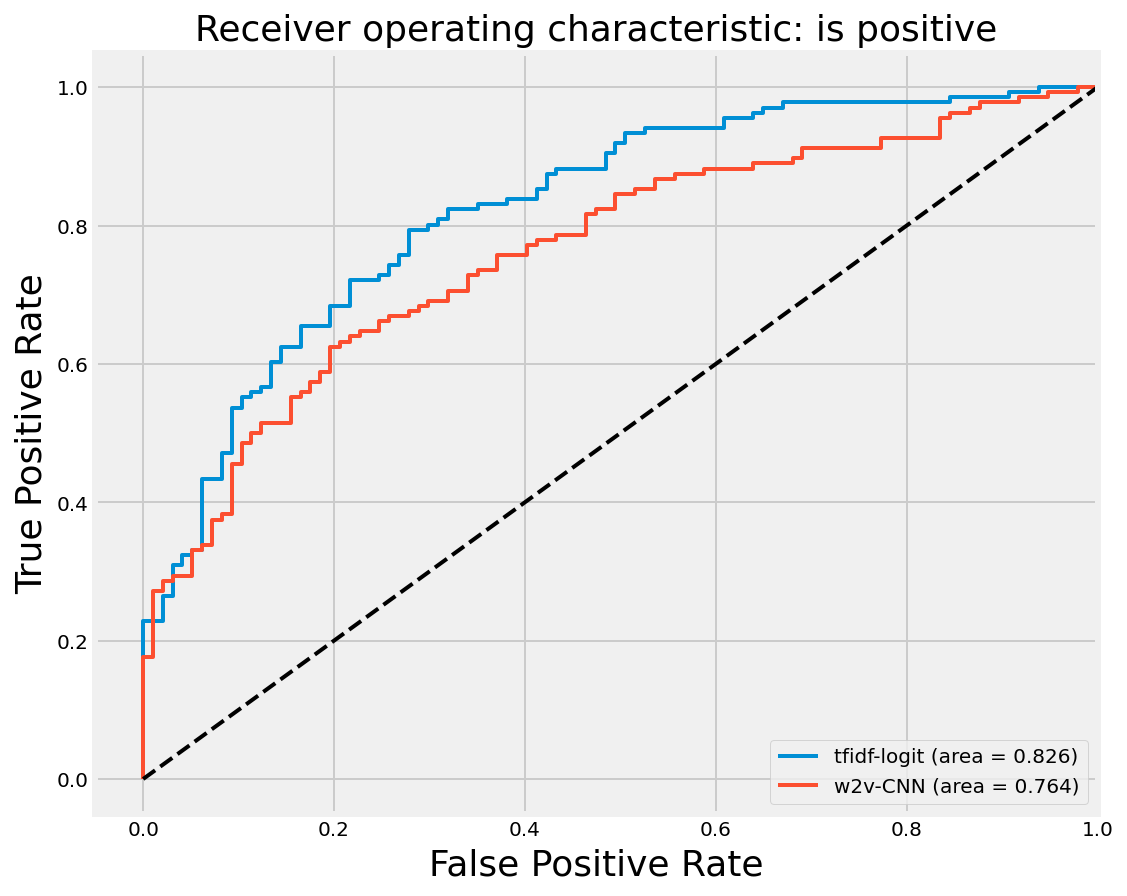

In [59]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [60]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from random import seed
import requests
import urllib
import time
import pandas as pd
import numpy as np
import datetime
import pickle
import matplotlib.pyplot as plt
from pprint import pprint
import re
from nltk.tokenize import WordPunctTokenizer
from tqdm.notebook import tqdm
from socket import timeout
import socket

In [61]:
date_list = []
for i in range(2018,2023,1):
  for j in range(1,13,1):
    for k in range(1,32,1):
      l = str(j) if j >= 10 else "0"+str(j)
      m = str(k) if k >= 10 else "0"+str(k)
      date_list.append(str(i)+"-"+l+"-"+m)

In [94]:
import random
head_1 = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.79 Safari/537.36'}
head_2 = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}
head_3 = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}
head_4 = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.53 Safari/537.36'}
head_5 = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.84 Safari/537.36'}
head_6 = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
head_7 = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2919.83 Safari/537.36'}
head_8 = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2866.71 Safari/537.36'}
head_9 = {'User-Agent' : 'Mozilla/5.0 (X11; Ubuntu; Linux i686 on x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2820.59 Safari/537.36'}
head_10 = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2762.73 Safari/537.36'}
head_11 = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/49.0.2656.18 Safari/537.36'}

header_l = [head_1, head_2, head_3, head_4, head_5, head_6, head_7, head_8, head_9, head_10, head_11]

def scraper(rdate):
  art_dict = {}
  # for i in tqdm(date_list[-31:]):
  page = "https://www.dawn.com/newspaper/business/"+rdate
  req1 = urllib.request.Request(page, headers = random.choice(header_l))
  html_page = urlopen(req1)
  # html_page = urlopen(page)
  soup = BeautifulSoup(html_page,"lxml")
  if soup.find_all("h2",{"class" : "story__title"}):
      for link in tqdm(soup.find_all("a",{"class" : "story__link"})):
          if "http" in link.get("href"):
              links = link.get("href")
              req2 = urllib.request.Request(links, headers = random.choice(header_l))
              html_page_1 = urlopen(req2)
              # html_page_1 = urlopen(links)
              soup = BeautifulSoup(html_page_1,"lxml")
              body = soup.body
              for paragraph in body.find_all("div", class_="story__content"):
                  art_dict[links] = [paragraph.text]
  # len(list(art_dict.keys()))

  cols = ["links","article"]
  fdf = pd.DataFrame(art_dict).transpose().reset_index()
  fdf.columns = cols

  fdf["length"] = [len(t) for t in fdf.article]

  data_dict = {'article':{'type':fdf.article.dtype,'description':'article text'},
              'length':{'type':fdf.length.dtype,'description':'Length of the article before cleaning'},
              'dataset_shape':fdf.shape}

  tok = WordPunctTokenizer()
  plt.style.use('fivethirtyeight')

  pat1 = r'@[A-Za-z0-9_]+'
  pat2 = r'https?://[^ ]+'
  combined_pat = r'|'.join((pat1, pat2))
  www_pat = r'www.[^ ]+'
  negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                  "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                  "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                  "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                  "mustn't":"must not"}
  neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

  def article_cleaner(article):
      soup = BeautifulSoup(article, 'lxml')
      souped = soup.get_text()
      try:
          bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
      except:
          bom_removed = souped
      stripped = re.sub(combined_pat, '', bom_removed)
      stripped = re.sub(www_pat, '', stripped)
      stripped = re.sub("googletag cmd push function googletag display saqib mrec sra", "", stripped)
      lower_case = stripped.lower()
      neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
      letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)        # During the letters_only process two lines above, it has created unnecessay white spaces, I will tokenize and join together to remove unneccessary white spaces
      words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
      return (" ".join(words)).strip()

  clean_article_text = []
  for index in range(len(fdf["article"])):
      clean_article_text.append(article_cleaner(fdf["article"][index]))

  fdf["clean_article"] = clean_article_text
  fdf["length"] = [len(t) for t in clean_article_text]
  
  article = fdf["clean_article"].values

  predict_lr = lr_with_tfidf.predict_proba(tvec.transform(article))

  sequences_daily = tokenizer.texts_to_sequences(article)
  daily_seq = pad_sequences(sequences_daily, maxlen=1500)

  predict_cnn = loaded_CNN_model.predict(daily_seq)

  fdf["prediction_cnn"] = predict_cnn
  fdf["prediction_lr"] = predict_lr[:,1]

  average_sentiment_cnn = np.average(fdf["prediction_cnn"])
  average_sentiment_lr = np.average(fdf["prediction_lr"])
  # print("CNN:", average_sentiment_cnn, "\nLR:", average_sentiment_lr)
  average_sentiment = (average_sentiment_lr + average_sentiment_cnn)/2
  # print("Average Sentiment:", average_sentiment)

  return fdf, average_sentiment

In [160]:
date_for_trend = "2022-12-27"
idx = date_list.index(date_for_trend)
weekly_dict = {}
avg_sent = {}
for i in range(0,3,1):
  weekly_dict[date_list[idx - i]], avg_sent[date_list[idx - i]] = scraper(date_list[idx - i])
  time.sleep(10)

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 93ms/step


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 [==============================] - 0s 181ms/step


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 101ms/step


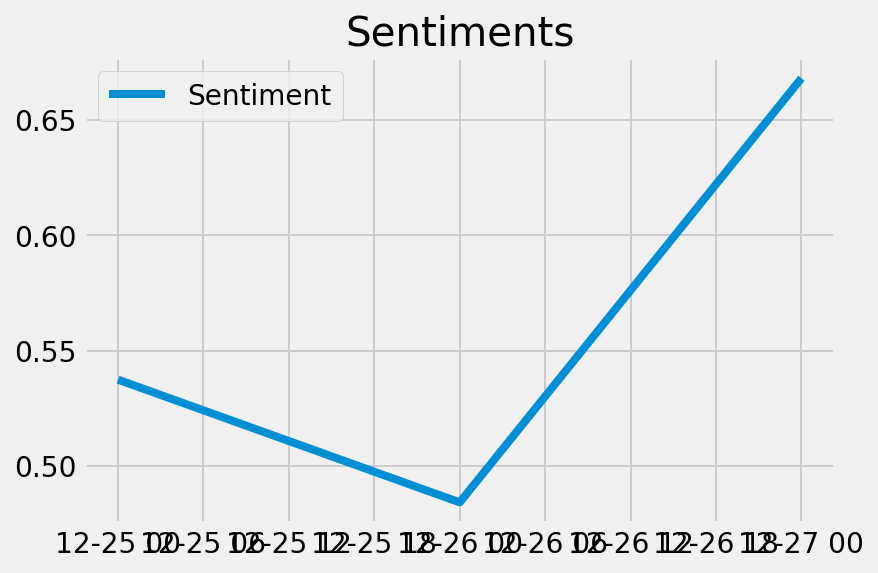

In [167]:
from matplotlib.pyplot import figure

avg_df = pd.DataFrame(avg_sent, index = range(0,len(list(avg_sent.keys())))).transpose().reset_index()
avg_df.drop(columns = [1, 2], inplace = True)
avg_df.columns = ["Date", "Sentiment"]
avg_df.index = avg_df["Date"].astype("datetime64")
avg_df.drop(columns = ["Date"], inplace = True)
plt.plot(avg_df.index, avg_df["Sentiment"], label = "Sentiment")
plt.title("Sentiments")
plt.legend()
plt.show()

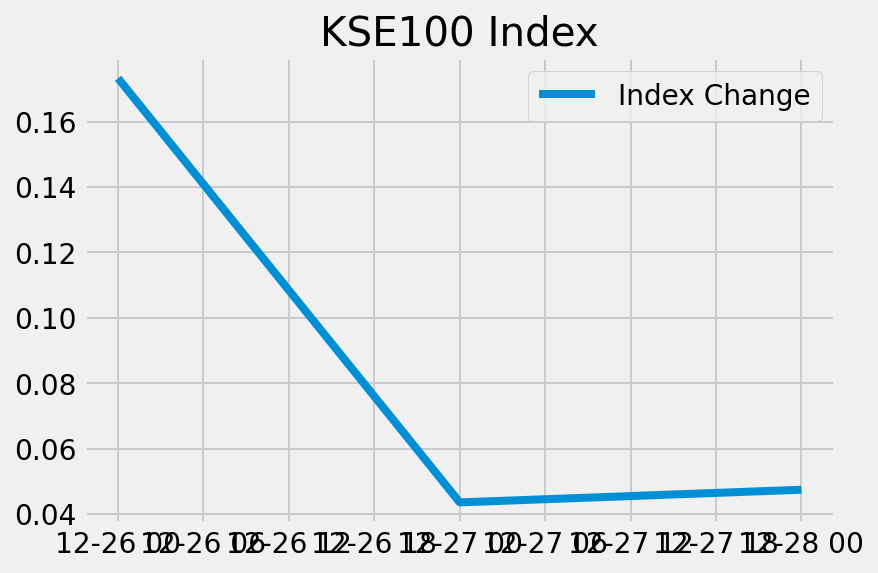

In [168]:
KSE100 = pd.read_csv("HBLTTI.csv")
KSE100["Date"] = KSE100["Date"].astype("datetime64")
KSE100.index = KSE100["Date"]
KSE100.drop(columns = ["Date", "Open Index", "Closing Index", "Change in Index"], inplace = True)
KSE100.dropna(inplace = True)
plt.plot(KSE100.index[3:6], KSE100.iloc[4:7]["Change Percentage"], label = "Index Change")
plt.title("KSE100 Index")
plt.legend()
plt.show()

Average Sentiment: 0.6680269559275419
The market sentiment is positive


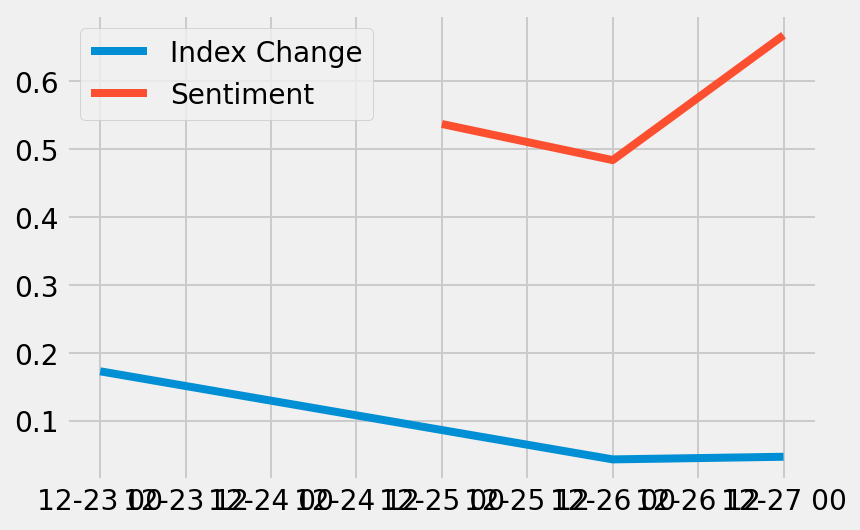

In [170]:
average_sentiment = avg_df["Sentiment"].values[0]
print("Average Sentiment:", average_sentiment)
if average_sentiment > 0.8:
    print("The market sentiment is highly positive")
elif ((average_sentiment > 0.5) | (average_sentiment <= 0.8)):
    print("The market sentiment is positive")
elif ((average_sentiment > 0.2) | (average_sentiment <= 0.5)):
    print("The market sentiment is negative")
else:
    print("The market sentiment is highly negative")

plt.plot(KSE100.index[4:7], KSE100.iloc[4:7]["Change Percentage"], label = "Index Change")
plt.plot(avg_df.index, avg_df["Sentiment"], label = "Sentiment")
plt.legend()
plt.show()

In [179]:
weekly_dict.keys()

dict_keys(['2022-12-27', '2022-12-26', '2022-12-25'])

In [175]:
weekly_dict[list(weekly_dict.keys())[0]]

,links,article,length,clean_article,prediction_cnn,prediction_lr
0,https://www.dawn.com/news/1728434/govt-weighs-...,ISLAMABAD: The government on Monday decided to...,3762,islamabad the government on monday decided to ...,0.638259,0.567487
1,https://www.dawn.com/news/1728433/dollar-fligh...,KARACHI: Confirming what has been known as an ...,2859,karachi confirming what has been known as an o...,0.193709,0.460887
2,https://www.dawn.com/news/1728432/pak-suzuki-s...,KARACHI: Pak Suzuki Motor Company Ltd (PSMCL) ...,1381,karachi pak suzuki motor company ltd psmcl on ...,0.526130,0.553768
3,https://www.dawn.com/news/1728431/nine-mous-si...,ISLAMABAD: Pakistan and Uzbekistan on Tuesday ...,1322,islamabad pakistan and uzbekistan on tuesday s...,0.915612,0.734202
4,https://www.dawn.com/news/1728430/rs370bn-inve...,ISLAMABAD: The National Transmission and Despa...,3211,islamabad the national transmission and despat...,0.975499,0.733086
5,https://www.dawn.com/news/1728429/energy-equip...,KARACHI: Energy equipment distributor NetLine ...,1788,karachi energy equipment distributor netline l...,0.975183,0.732122
6,https://www.dawn.com/news/1728428/stocks-rally...,KARACHI: Trading on the stock exchange remaine...,1801,karachi trading on the stock exchange remained...,0.779082,0.567351


In [176]:
weekly_dict[list(weekly_dict.keys())[1]]

,links,article,length,clean_article,prediction_cnn,prediction_lr
0,https://www.dawn.com/news/1728229/kse-100-shar...,\n\nChart by Rehan Ahmed\n\n \nPublished in Da...,82,chart by rehan ahmed published in dawn the bus...,0.890970,0.651984
1,https://www.dawn.com/news/1728227/rupee-report...,"\n\nChart by RA\n\n \nPublished in Dawn, The B...",73,chart by ra published in dawn the business and...,0.898609,0.647016
2,https://www.dawn.com/news/1728224/company-news,Co-branded lubricant products\nHyundai Nishat ...,4382,co branded lubricant products hyundai nishat m...,0.976595,0.700881
3,https://www.dawn.com/news/1728222/tracing-the-...,"We, as a nation, produce much less than we con...",6019,we as nation produce much less than we consume...,0.139047,0.398275
4,https://www.dawn.com/news/1728218/fishing-for-...,Pakistan’s fish and fish preparations exports ...,5869,pakistan fish and fish preparations exports ha...,0.647771,0.484821
5,https://www.dawn.com/news/1728236/saving-water...,There was a time when you could step into the ...,4752,there was time when you could step into the ba...,0.578411,0.491548
6,https://www.dawn.com/news/1728235/troubles-lur...,Pakistan will head into 2023 with an incredibl...,5927,pakistan will head into with an incredibly glo...,0.266991,0.361986
7,https://www.dawn.com/news/1728234/why-is-pakis...,"According to many agricultural economists, cur...",7000,according to many agricultural economists curr...,0.392436,0.575711
8,https://www.dawn.com/news/1728231/finance-igno...,Pakistan is facing a severe foreign exchange c...,5108,pakistan is facing severe foreign exchange cri...,0.145130,0.434884
9,https://www.dawn.com/news/1728225/short-sighte...,Pakistan has not run out of gas overnight. At ...,6052,pakistan has not run out of gas overnight at t...,0.145710,0.493891


In [177]:
weekly_dict[list(weekly_dict.keys())[2]]

,links,article,length,clean_article,prediction_cnn,prediction_lr
0,https://www.dawn.com/news/1728120/exports-to-m...,ISLAMABAD: Pakistan’s exports to the Middle Ea...,2399,islamabad pakistan exports to the middle east ...,0.499342,0.493647
1,https://www.dawn.com/news/1728119/fighting-cli...,KARACHI: When the master of ceremonies opened ...,2718,karachi when the master of ceremonies opened t...,0.786505,0.616363
2,https://www.dawn.com/news/1728118/alvi-wants-m...,KARACHI: President Dr Arif Alvi on Saturday ur...,1917,karachi president dr arif alvi on saturday urg...,0.965394,0.719767
3,https://www.dawn.com/news/1728117/ecb-must-be-...,FRANKFURT: The European Central Bank must be p...,1201,frankfurt the european central bank must be pr...,0.312856,0.504835
4,https://www.dawn.com/news/1728116/india-should...,NEW DELHI: India’s future interest rate hikes ...,2376,new delhi india future interest rate hikes sho...,0.363624,0.520778
5,https://www.dawn.com/news/1728115/german-infla...,BERLIN: Inflation is likely to remain high for...,1855,berlin inflation is likely to remain high for ...,0.257058,0.513189
6,https://www.dawn.com/news/1728114/political-no...,KARACHI: The stock market remained bearish in ...,2328,karachi the stock market remained bearish in t...,0.414606,0.397933
7,https://www.dawn.com/news/1728113/tesla-suspen...,SHANGHAI: Tesla suspended production at its Sh...,1747,shanghai tesla suspended production at its sha...,0.641701,0.590547


In [178]:
print(avg_df.index[0])
print(KSE100.index[4])
avg_df.index[0] == KSE100.index[4]

2022-12-27 00:00:00
2022-12-27 00:00:00


True

In [140]:
KSE100.iloc[4:7]

,Change Percentage
Date,
2022-12-27,0.047452
2022-12-26,0.043582
2022-12-23,0.173264


In [54]:
# import requests
# from random import randint

# SCRAPEOPS_API_KEY = '67b1b121-48fa-4f65-b22a-910c89b9d5d2'

# def get_headers_list():
#   response = requests.get('http://headers.scrapeops.io/v1/browser-headers?api_key=' + SCRAPEOPS_API_KEY)
#   # response = requests.get(url='https://headers.scrapeops.io/v1/browser-headers', params={'api_key': '67b1b121-48fa-4f65-b22a-910c89b9d5d2', 'num_headers': '15'})
#   json_response = response.json()
#   return json_response.get('result', [])

# def get_random_header(header_list):
#   random_index = randint(0, len(header_list) - 1)
#   return header_list[random_index]

# header_list = get_headers_list()